In [1]:
import os
import pandas as pd
import numpy as np 
import mlflow 
import sagemaker_mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [2]:
training_data = pd.read_csv(r"../aws_retail_ds_exp/training_data.csv")

In [3]:
# Calculate Revenue as price * demand
training_data['Revenue'] = training_data['SellingPrice'] * training_data['Demand']

# Apply log transformation to SellingPrice and Revenue
training_data['Log_SellingPrice'] = np.log(training_data['SellingPrice'])
training_data['Log_Revenue'] = np.log(training_data['Revenue'])

# Define the independent variables (X) as all columns, including the log-transformed SellingPrice
X = training_data.drop(columns=['Date', 'Revenue', 'Log_Revenue'])  # Drop non-numeric columns and the target
y = training_data['Log_Revenue']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
def custom_mape(y_true, y_pred, epsilon=1e-6):
    """
    Custom Mean Absolute Percentage Error that avoids division by zero and reduces bias
    towards small values.
    """
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + epsilon))) * 100

In [5]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn

import boto3
import numpy as np
import pandas as pd
import os

sagemaker.config INFO - Fetched defaults config from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix


In [6]:
# Define session, role, and region so we can
# perform any SageMaker tasks we need
sagemaker_session = sagemaker.Session()
role = get_execution_role()
region = sagemaker_session.boto_region_name


sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix


In [7]:
from sagemaker_studio import ClientConfig, Project

client_config = ClientConfig(region=region)
project = Project(config=client_config)

# Retrieve provisioned mlflow tracking server arn from the project
tracking_server_arn = project.mlflow_tracking_server_arn

In [8]:
tracking_server_arn

'arn:aws:sagemaker:us-east-1:952076796066:mlflow-tracking-server/dynamicpricingexperiment-butrpxfjd1cujr-am8vzf8t0py97r-dev'

In [9]:
# Set the Tracking Server URI using the ARN of the Tracking Server you created
mlflow.set_tracking_uri(tracking_server_arn)

In [10]:
mlflow.set_experiment("dynamic_pricing_experiment")

<Experiment: artifact_location='s3://amazon-sagemaker-952076796066-us-east-1-25b5f044d409/dzd_d5qitgymzlmqcn/butrpxfjd1cujr/dev/data/ml/mlflow/1', creation_time=1752087813766, experiment_id='1', last_update_time=1752087813766, lifecycle_stage='active', name='dynamic_pricing_experiment', tags={}>

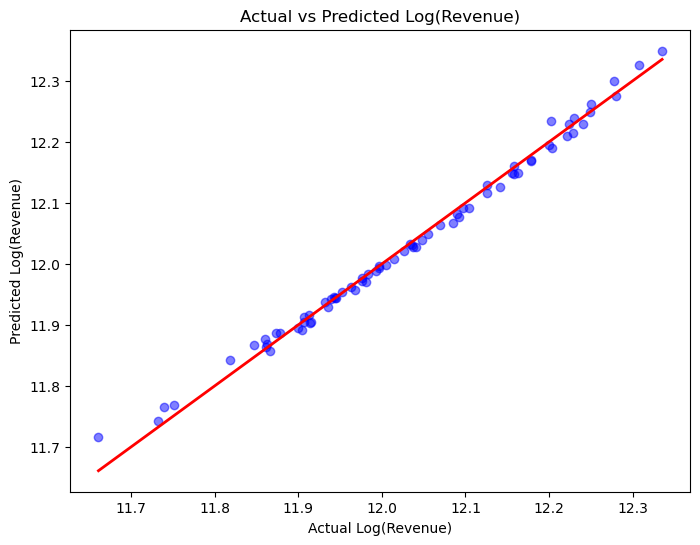

Coefficient: [ 3.52955014e-05 -6.08894330e-04 -2.21973519e-04  1.52619312e-04
  1.60953202e-06 -5.26185938e-08  3.23064379e-04  1.85640081e-04
  1.37424289e-04 -2.62096383e-05 -8.77523748e-13  7.48209506e-05
  1.71409974e-07  4.37249195e-13 -3.01332960e-13 -4.59327290e-02
 -7.62837917e-03 -8.89630556e-04  5.70960757e-03  2.89994277e-04
 -6.74096186e-03  3.66721699e-05 -1.66533454e-16  5.41233725e-16
  2.74077221e-01  6.34847903e-01  2.63586292e-05 -7.24528306e-03
  8.22638334e-05  3.68132803e-03 -2.65693025e-05 -8.85718041e-06
  1.41266028e-06  7.03554770e-05 -3.52870872e-03 -2.53702748e-01
  1.07067934e-01 -9.79874633e-04  0.00000000e+00  1.17109204e+00]
Intercept: 6.0572123160609115
Mean Squared Error (MSE): 0.00016185646255390625
R-squared: 0.9928351651178776
MAPE: 0.08%
🏃 View run adventurous-gnu-734 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/1/runs/7120d55560354c06af91b0978e6a8829
🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/1


In [11]:
# --- Your MLflow tracking code ---
with mlflow.start_run():
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    y_pred = lr_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mlflow.log_param("model_type", "Linear Regression")
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", r2)

    mape = custom_mape(y_test, y_pred, epsilon=1e-6)
    mlflow.log_metric("mape", mape)

    signature = mlflow.models.signature.infer_signature(X_train, y_train)
    # Explicitly set registered_model_name to None to ensure no registration attempt
    mlflow.sklearn.log_model(lr_model, "model", signature=signature, registered_model_name=None)
    
    for i, coef in enumerate(lr_model.coef_):
        mlflow.log_metric(f"coeff_{i}", coef)
    
    mlflow.log_metric("intercept", lr_model.intercept_)

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
    plt.xlabel("Actual Log(Revenue)")
    plt.ylabel("Predicted Log(Revenue)")
    plt.title("Actual vs Predicted Log(Revenue)")

    plot_file = "actual_vs_predicted_plot.png"
    plt.savefig(plot_file)
    mlflow.log_artifact(plot_file)
    plt.show()
    plt.close()

    print(f"Coefficient: {lr_model.coef_}")
    print(f"Intercept: {lr_model.intercept_}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared: {r2}")
    print(f"MAPE: {mape:.2f}%")

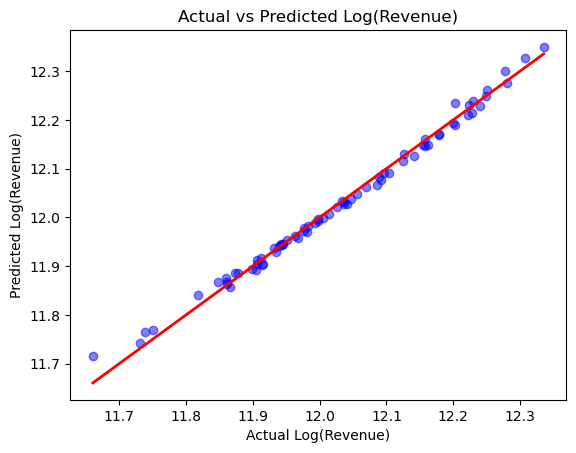

Coefficient: [ 3.52955014e-05 -6.08894330e-04 -2.21973519e-04  1.52619312e-04
  1.60953202e-06 -5.26185938e-08  3.23064379e-04  1.85640081e-04
  1.37424289e-04 -2.62096383e-05 -8.77523748e-13  7.48209506e-05
  1.71409974e-07  4.37249195e-13 -3.01332960e-13 -4.59327290e-02
 -7.62837917e-03 -8.89630556e-04  5.70960757e-03  2.89994277e-04
 -6.74096186e-03  3.66721699e-05 -1.66533454e-16  5.41233725e-16
  2.74077221e-01  6.34847903e-01  2.63586292e-05 -7.24528306e-03
  8.22638334e-05  3.68132803e-03 -2.65693025e-05 -8.85718041e-06
  1.41266028e-06  7.03554770e-05 -3.52870872e-03 -2.53702748e-01
  1.07067934e-01 -9.79874633e-04  0.00000000e+00  1.17109204e+00]
Intercept: 6.0572123160609115
Mean Squared Error (MSE): 0.00016185646255390625
R-squared: 0.9928351651178776
MAPE: 0.08%
🏃 View run monumental-worm-252 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/1/runs/d18338fc0c064082a18703a6d970ce19
🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/1


In [12]:
# Set up MLflow experiment
#mlflow.set_experiment("dynamic_pricing_experiment")

# Start an MLflow run
with mlflow.start_run():
    # Train the log-log regression model using linear regression on the log-transformed variables
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = lr_model.predict(X_test)

    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Log the model parameters (e.g., model type, training size)
    mlflow.log_param("model_type", "Linear Regression")
    mlflow.log_param("train_size", len(X_train))

    # Log metrics
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", r2)

    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = custom_mape(y_test, y_pred, epsilon=1e-6)
    mlflow.log_metric("mape", mape)

    # Log the model itself (with signature for inputs and outputs)
    signature = mlflow.models.signature.infer_signature(X_train, y_train)
    mlflow.sklearn.log_model(lr_model, "model", signature=signature)
    
     # Log model coefficients and intercept as separate metrics
    for i, coef in enumerate(lr_model.coef_):
        mlflow.log_metric(f"coeff_{i}", coef)  # Log each coefficient as a separate metric
    
    # Log intercept as a metric
    mlflow.log_metric("intercept", lr_model.intercept_)

    # Plotting the actual vs predicted log(revenue)
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
    plt.xlabel("Actual Log(Revenue)")
    plt.ylabel("Predicted Log(Revenue)")
    plt.title("Actual vs Predicted Log(Revenue)")

    # Save plot as artifact
    plot_file = "actual_vs_predicted_plot.png"
    plt.savefig(plot_file)
    mlflow.log_artifact(plot_file)

    # Display plot
    plt.show()

    # Print regression coefficients and metrics
    print(f"Coefficient: {lr_model.coef_}")
    print(f"Intercept: {lr_model.intercept_}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared: {r2}")
    print(f"MAPE: {mape:.2f}%")


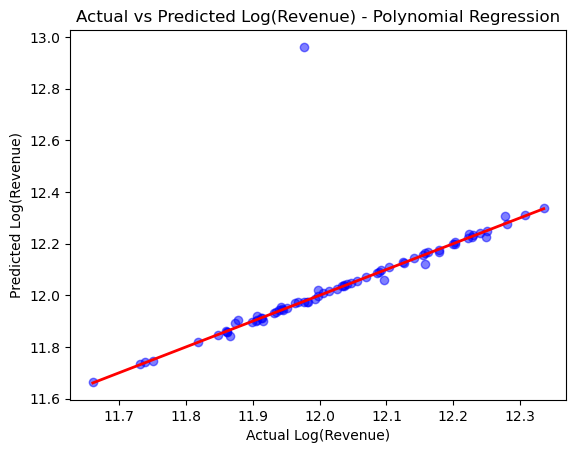

Root Mean Squared Error (RMSE): 0.11576613507447468
Mean Squared Error (MSE): 0.013401798030081517
R-squared: 0.4067480007039761
Mean Absolute Percentage Error (MAPE): 0.16%
🏃 View run useful-fox-595 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/1/runs/4d2acd11bb6f438998f542272b374f98
🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/1


In [13]:


# Start an MLflow run
with mlflow.start_run():
    # Initialize PolynomialFeatures with the degree of the polynomial (e.g., degree=3 for cubic features)
    poly = PolynomialFeatures(degree=3)  # Change degree to control polynomial complexity
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Log the degree of the polynomial
    mlflow.log_param("polynomial_degree", 3)

    # Train the polynomial regression model using linear regression on the polynomial features
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_poly)

    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)


    # Calculate MAPE
    mape = custom_mape(y_test, y_pred, epsilon=1e-6)

    # Log the evaluation metrics to MLflow
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mape", mape)

    # Log the model itself (with signature for inputs and outputs)
    signature = mlflow.models.signature.infer_signature(X_train_poly, y_train)
    mlflow.sklearn.log_model(model, "polynomial_regression_model", signature=signature)

    # Log the model coefficients as separate metrics
    for i, coef in enumerate(model.coef_):
        mlflow.log_metric(f"coeff_{i}", coef)  # Log each coefficient as a separate metric
    
    # Log intercept as a metric
    mlflow.log_metric("intercept", model.intercept_)

    # Plotting the actual vs predicted log(revenue)
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
    plt.xlabel("Actual Log(Revenue)")
    plt.ylabel("Predicted Log(Revenue)")
    plt.title("Actual vs Predicted Log(Revenue) - Polynomial Regression")

    # Save plot as artifact
    plot_file = "actual_vs_predicted_plot.png"
    plt.savefig(plot_file)
    mlflow.log_artifact(plot_file)

    # Display plot
    plt.show()

    # Print regression coefficients and metrics
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared: {r2}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

In [ ]:


# Start an MLflow run
with mlflow.start_run():
    # Initialize PolynomialFeatures with the degree of the polynomial (e.g., degree=3 for cubic features)
    poly = PolynomialFeatures(degree=3)  # Change degree to control polynomial complexity
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Log the degree of the polynomial
    mlflow.log_param("polynomial_degree", 3)

    # Train the polynomial regression model using linear regression on the polynomial features
    # Apply Ridge regression (L2 Regularization)
    ridge_model = Ridge(alpha=1.0)  # You can adjust alpha for more/less regularization
    ridge_model.fit(X_train_poly, y_train)


    # Make predictions on the test set
    y_pred_ridge = ridge_model.predict(X_test_poly)


    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred_ridge)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_ridge)


    # Calculate MAPE
    mape = custom_mape(y_test, y_pred_ridge, epsilon=1e-6)

    # Log the evaluation metrics to MLflow
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mape", mape)

    # Log the model itself (with signature for inputs and outputs)
    signature = mlflow.models.signature.infer_signature(X_train_poly, y_train)
    mlflow.sklearn.log_model(model, "polynomial_regression_model", signature=signature)

    # Log the model coefficients as separate metrics
    for i, coef in enumerate(model.coef_):
        mlflow.log_metric(f"coeff_{i}", coef)  # Log each coefficient as a separate metric
    
    # Log intercept as a metric
    mlflow.log_metric("intercept", model.intercept_)

    # Plotting the actual vs predicted log(revenue)
    plt.scatter(y_test, y_pred_ridge, color='blue', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
    plt.xlabel("Actual Log(Revenue)")
    plt.ylabel("Predicted Log(Revenue)")
    plt.title("Actual vs Predicted Log(Revenue) - Polynomial Regression")

    # Save plot as artifact
    plot_file = "actual_vs_predicted_plot.png"
    plt.savefig(plot_file)
    mlflow.log_artifact(plot_file)

    # Display plot
    plt.show()

    # Print regression coefficients and metrics
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared: {r2}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

In [ ]:


# Start an MLflow run
with mlflow.start_run():
    # Initialize PolynomialFeatures with the degree of the polynomial (e.g., degree=3 for cubic features)
    poly = PolynomialFeatures(degree=3)  # Change degree to control polynomial complexity
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Log the degree of the polynomial
    mlflow.log_param("polynomial_degree", 3)

    # Train the polynomial regression model using linear regression on the polynomial features
    # Apply Lasso regression (L1 Regularization)
    lasso_model = Lasso(alpha=0.01)  # You can adjust alpha for more/less regularization
    lasso_model.fit(X_train_poly, y_train)


    # Make predictions on the test set
    y_pred_lasso = lasso_model.predict(X_test_poly)


    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred_lasso)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_lasso)


    # Calculate MAPE
    mape = custom_mape(y_test, y_pred_lasso, epsilon=1e-6)

    # Log the evaluation metrics to MLflow
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mape", mape)

    # Log the model itself (with signature for inputs and outputs)
    signature = mlflow.models.signature.infer_signature(X_train_poly, y_train)
    mlflow.sklearn.log_model(model, "polynomial_regression_model", signature=signature)

    # Log the model coefficients as separate metrics
    for i, coef in enumerate(model.coef_):
        mlflow.log_metric(f"coeff_{i}", coef)  # Log each coefficient as a separate metric
    
    # Log intercept as a metric
    mlflow.log_metric("intercept", model.intercept_)

    # Plotting the actual vs predicted log(revenue)
    plt.scatter(y_test, y_pred_lasso, color='blue', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
    plt.xlabel("Actual Log(Revenue)")
    plt.ylabel("Predicted Log(Revenue)")
    plt.title("Actual vs Predicted Log(Revenue) - Polynomial Regression")

    # Save plot as artifact
    plot_file = "actual_vs_predicted_plot.png"
    plt.savefig(plot_file)
    mlflow.log_artifact(plot_file)

    # Display plot
    plt.show()

    # Print regression coefficients and metrics
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared: {r2}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")